In [1]:
import Pkg
Pkg.add("Plots")
Pkg.add("Distributions")
Pkg.add("Flux")
Pkg.add("CUDA")
Pkg.add("cuDNN")
Pkg.add("ProgressMeter")
import Pkg; Pkg.add("Optimisers")
using Plots

   Resolving package versions...
  No Changes to `/global/u1/s/soham/.julia/environments/v1.9/Project.toml`
  No Changes to `/global/u1/s/soham/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `/global/u1/s/soham/.julia/environments/v1.9/Project.toml`
  No Changes to `/global/u1/s/soham/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `/global/u1/s/soham/.julia/environments/v1.9/Project.toml`
  No Changes to `/global/u1/s/soham/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `/global/u1/s/soham/.julia/environments/v1.9/Project.toml`
  No Changes to `/global/u1/s/soham/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `/global/u1/s/soham/.julia/environments/v1.9/Project.toml`
  No Changes to `/global/u1/s/soham/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `/global/u1/s/soham/.julia/envi

In [1]:
# energy(x; k=1, x0=0) = @. 0.5*k*(x-x0)^2
energy(x; a=2, k=1) = @. 0.25*k*((x-a)^2) * ((x+a)^2)
#force(x; k=1, x0=0) = @. -k*(x-x0)
force(x; a=2, k=1) = @. -k*x*(x-a)*(x+a)

force (generic function with 1 method)

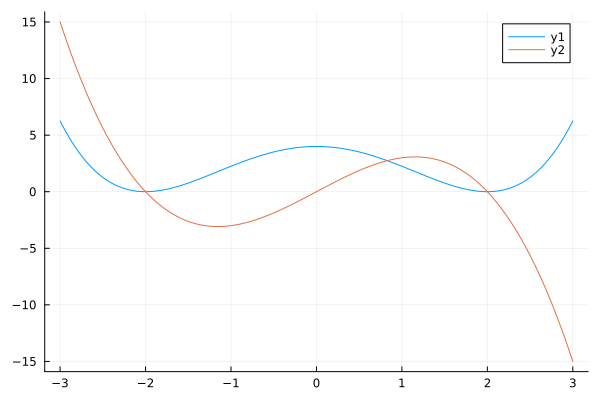

In [37]:
x = range(-3, 3, 100)
e = energy(x)
f = force(x)
plot(x, e)
plot!(x, f)

In [38]:
using Random, Distributions

In [39]:
Random.seed!(123)

TaskLocalRNG()

In [40]:
#this is step A
position_update(x, v, dt) = @. x + v*dt/2.

#this is step B
velocity_update(v,F,dt) = @. v + F*dt/2.

function random_velocity_update(
        v::AbstractVector, gamma::Number, kBT::Number, dt::Number;
        d=Normal(0, 1)
    )
    R = rand(d, length(v))
    c1 = @. exp(-gamma*dt)
    c2 = @. sqrt(1-c1*c1)*sqrt(kBT)
    v_new = @. c1*v + R*c2
    return v_new
end

random_velocity_update(
    v::Number, gamma::Number, kBT::Number, dt::Number; d=Normal(0, 1)
) = only(random_velocity_update([v], gamma, kBT, dt; d))

random_velocity_update (generic function with 2 methods)

In [41]:
function baoab(
        energy::Function, force::Function, max_time, dt,
        gamma, kBT, initial_position::T, initial_velocity::T;
        save_frequency = 3, kwargs...
    ) where T <: Number
    
    x = initial_position
    v = initial_velocity
    t = 0
    step_number = 0
    positions = T[]
    velocities = T[]
    total_energies = T[]
    save_times = T[]
    
    while t < max_time
        # B
        potential_force = force(x; kwargs...)
        v = velocity_update(v, potential_force, dt)
        # A
        x = position_update(x, v, dt)
        # O
        v = random_velocity_update(v, gamma, kBT, dt)
        # A
        x = position_update(x, v, dt)
        # B
        potential_force = force(x; kwargs...)
        v = velocity_update(v, potential_force, dt)
        
        potential_energy = energy(x; kwargs...)
        if step_number%save_frequency == 0 && step_number>0
            e_total = @. .5*v*v + potential_energy

            push!(positions, x)
            push!(velocities, v)
            push!(total_energies, e_total)
            push!(save_times, t)
        end
        
        t = @. t+dt
        step_number = @. step_number + 1
    end
    
    return save_times, positions, velocities, total_energies
end

baoab (generic function with 1 method)

In [42]:
my_k = 2
my_max_time = 100
initial_position = .1
initial_velocity = .5

my_gamma=0.5
my_kBT=3.0
my_dt=0.01

times, positions, velocities, total_energies = baoab(
    energy, force, my_max_time, my_dt, 
    my_gamma, my_kBT,
    initial_position, initial_velocity;
    k=my_k
)

([0.03, 0.060000000000000005, 0.09, 0.11999999999999998, 0.15, 0.18000000000000002, 0.21000000000000005, 0.24000000000000007, 0.2700000000000001, 0.3000000000000001  …  99.72000000001411, 99.75000000001413, 99.78000000001414, 99.81000000001416, 99.84000000001417, 99.87000000001419, 99.9000000000142, 99.93000000001422, 99.96000000001423, 99.99000000001425], [0.1058994443581533, 0.10642966517372679, 0.11455106089719616, 0.12351447260129123, 0.13028405528431766, 0.13725986257966222, 0.1420619321739243, 0.13798515280837786, 0.13699758770809753, 0.1434822749972319  …  -2.258288780177797, -2.3057610402452657, -2.3500876936755577, -2.3997964539093326, -2.443402361721813, -2.4834403599730526, -2.5130946078995224, -2.521062274898885, -2.4981197035884635, -2.4615041222204623], [-0.15349542799940452, 0.14047872183733157, 0.2702234991362963, 0.2507253736889553, 0.2624967874064956, 0.23776325574056978, -0.0064130534799356105, -0.10568228985530952, 0.053993511922172645, 0.45132887554179457  …  -1.73

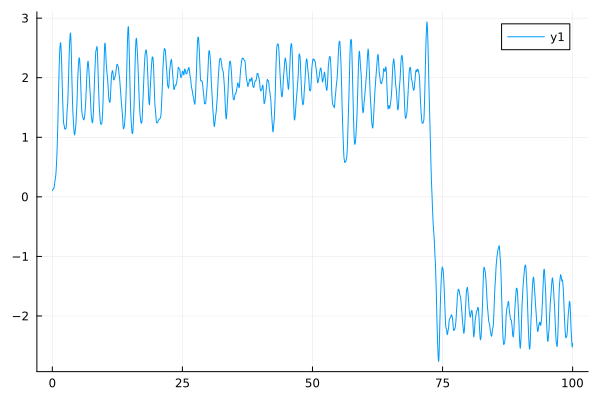

In [43]:
plot(times, positions)

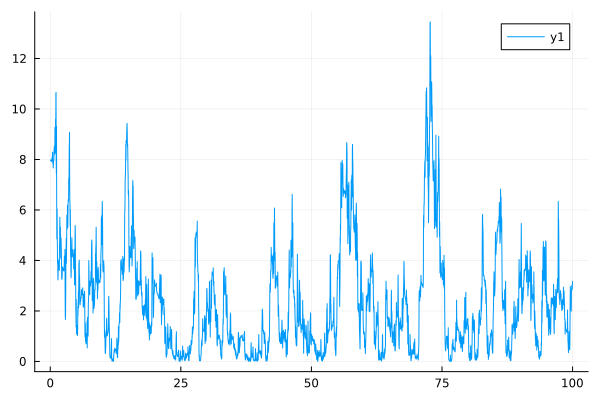

In [44]:
plot(times, total_energies)

In [45]:
function baoab_ensemble(
        energy::Function, force::Function, max_time, dt,
        gamma, kBT, initial_position::T, initial_velocity::T;
        save_frequency = 3, ensemble = (len=10, d=Normal(0, 0.01), n=10, st=10),
        kwargs...
    ) where T <: Number
    
    times, positions, velocities, total_energies = baoab(
        energy, force, max_time, dt,
        gamma, kBT, initial_position::T, initial_velocity::T;
        save_frequency=save_frequency, kwargs...
    )
    
    ensemble_t = Array{T, 1}[]
    ensemble_p = Array{T, 1}[]
    ensemble_v = Array{T, 1}[]
    for (t, p, v) in zip(
            times[1:ensemble.st:end],
            positions[1:ensemble.st:end],
            velocities[1:ensemble.st:end]
        )
        p_r = rand(ensemble.d, ensemble.n)
        v_r = rand(ensemble.d, ensemble.n)        

        for i in 1:ensemble.n
            t_i, p_i, v_i, _ = baoab(
                energy, force, ensemble.len*dt, dt,
                gamma, kBT, p + p_r[i], v + v_r[i];
                save_frequency=save_frequency, kwargs...
            )
            push!(ensemble_t, t .+ t_i)
            push!(ensemble_p, p_i)
            push!(ensemble_v, v_i)

        end
    end

    return times, positions, velocities, total_energies, (t=ensemble_t, p=ensemble_p, v=ensemble_v)
end

baoab_ensemble (generic function with 1 method)

In [46]:
times, positions, velocities, total_energies, ensemble = baoab_ensemble(
    energy, force, my_max_time/4, my_dt, 
    my_gamma, my_kBT,
    initial_position, initial_velocity;
    k=my_k, ensemble = (len=80, d=Normal(0, 0.001), n=100, st=1)
);

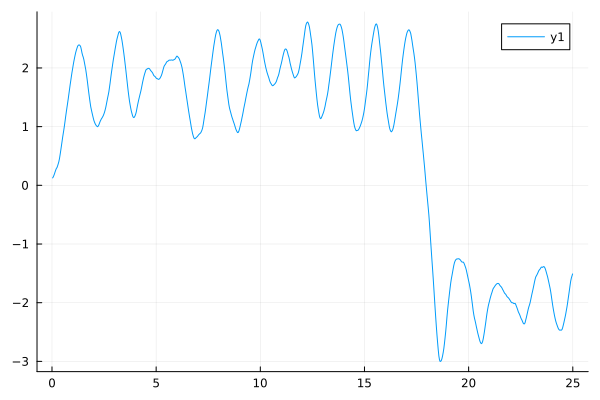

In [47]:
plot(times, positions)

In [48]:
ensemble_set_p = Dict{Float64}{Set{Float64}}()
ensemble_range_p = Dict{Float64}{Tuple{Float64, Float64}}()

for i in 1:length(ensemble.t)
    k = ensemble.t[i][end]
    s = get!(ensemble_set_p, k, Set{Float64}())
    push!(s, ensemble.p[i][end])
end

for k in keys(ensemble_set_p)
    s = ensemble_set_p[k]
    ensemble_range_p[k] = (minimum(s), maximum(s))
end

ensemble_t  = sort(collect(keys(ensemble_range_p)))
ensemble_lo = [ensemble_range_p[t][1] for t in ensemble_t]
ensemble_hi = [ensemble_range_p[t][2] for t in ensemble_t]

delta_t = ensemble_t[1] - times[1]

0.7800000000000005

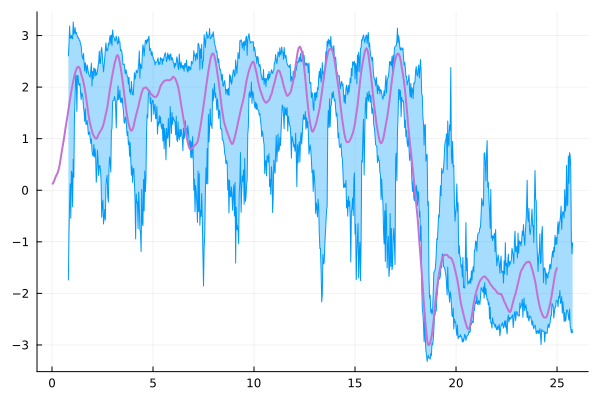

In [49]:
plot(ensemble_t, ensemble_hi, c = 1)
plot!(ensemble_t, ensemble_lo, fillrange = ensemble_hi, fillalpha = 0.35, c = 1)
plot!(times, positions; linewidth=2, c=4, legend=false)

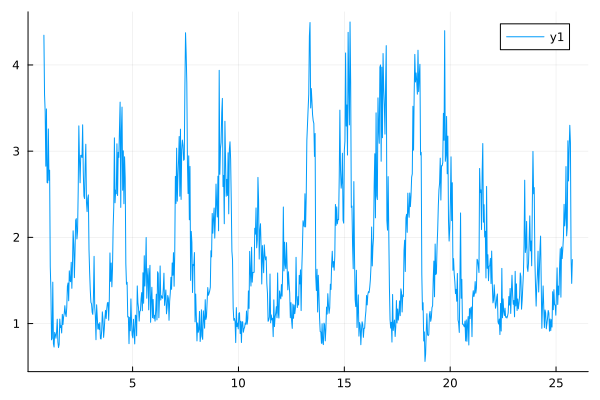

In [50]:
plot(ensemble_t, ensemble_hi-ensemble_lo, c = 1)

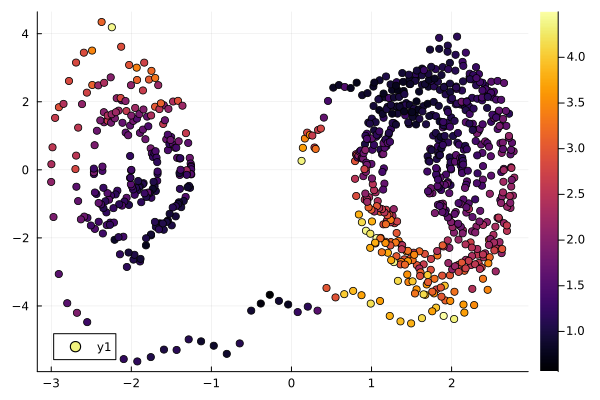

In [51]:
scatter(positions, velocities, markershape=:circ, zcolor=ensemble_hi-ensemble_lo)

In [33]:
# This will prompt if neccessary to install everything, including CUDA:
using Flux, CUDA, Statistics, ProgressMeter

# Generate some data for the XOR problem: vectors of length 2, as columns of a matrix:
noisy = rand(Float32, 2, 1000)                                    # 2×1000 Matrix{Float32}
truth = [xor(col[1]>0.5, col[2]>0.5) for col in eachcol(noisy)]   # 1000-element Vector{Bool}

# Define our model, a multi-layer perceptron with one hidden layer of size 3:
model = Chain(
    Dense(2 => 3, tanh),   # activation function inside layer
    BatchNorm(3),
    Dense(3 => 2),
    softmax) |> gpu        # move model to GPU, if available

# The model encapsulates parameters, randomly initialised. Its initial output is:
out1 = model(noisy |> gpu) |> cpu                                 # 2×1000 Matrix{Float32}

# To train the model, we use batches of 64 samples, and one-hot encoding:
target = Flux.onehotbatch(truth, [true, false])                   # 2×1000 OneHotMatrix
loader = Flux.DataLoader((noisy, target) |> gpu, batchsize=64, shuffle=true);
# 16-element DataLoader with first element: (2×64 Matrix{Float32}, 2×64 OneHotMatrix)

optim = Flux.setup(Flux.Adam(0.01), model)  # will store optimiser momentum, etc.

# Training loop, using the whole data set 1000 times:
losses = []
@showprogress for epoch in 1:1_000
    for (x, y) in loader
        loss, grads = Flux.withgradient(model) do m
            # Evaluate model and loss inside gradient context:
            y_hat = m(x)
            Flux.crossentropy(y_hat, y)
        end
        Flux.update!(optim, model, grads[1])
        push!(losses, loss)  # logging, outside gradient context
    end
end

optim # parameters, momenta and output have all changed
out2 = model(noisy |> gpu) |> cpu  # first row is prob. of true, second row p(false)

mean((out2[1,:] .> 0.5) .== truth)  # accuracy 94% so far!


┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt ~/.julia/packages/Flux/AQc9Q/ext/FluxCUDAExt/FluxCUDAExt.jl:57


LoadError: ArgumentError: Package ProgressMeter not found in current path.
- Run `import Pkg; Pkg.add("ProgressMeter")` to install the ProgressMeter package.

In [34]:
using Plots  # to draw the above figure

p_true = scatter(noisy[1,:], noisy[2,:], zcolor=truth, title="True classification", legend=false)
p_raw =  scatter(noisy[1,:], noisy[2,:], zcolor=out1[1,:], title="Untrained network", label="", clims=(0,1))
p_done = scatter(noisy[1,:], noisy[2,:], zcolor=out2[1,:], title="Trained network", legend=false)

plot(p_true, p_raw, p_done, layout=(1,3), size=(1000,330))

LoadError: UndefVarError: `noisy` not defined

In [ ]:
# This will prompt if neccessary to install everything, including CUDA:
using Flux, CUDA, Statistics, ProgressMeter

# Generate some data for the XOR problem: vectors of length 2, as columns of a matrix:
noisy = rand(Float32, 2, 1000)                                    # 2×1000 Matrix{Float32}
truth = [xor(col[1]>0.5, col[2]>0.5) for col in eachcol(noisy)]   # 1000-element Vector{Bool}

# Define our model, a multi-layer perceptron with one hidden layer of size 3:
model = Chain(
    Dense(2 => 3, tanh),   # activation function inside layer
    BatchNorm(3),
    Dense(3 => 2),
    softmax) |> gpu        # move model to GPU, if available

# The model encapsulates parameters, randomly initialised. Its initial output is:
out1 = model(noisy |> gpu) |> cpu                                 # 2×1000 Matrix{Float32}

# To train the model, we use batches of 64 samples, and one-hot encoding:
target = Flux.onehotbatch(truth, [true, false])                   # 2×1000 OneHotMatrix
loader = Flux.DataLoader((noisy, target) |> gpu, batchsize=64, shuffle=true);
# 16-element DataLoader with first element: (2×64 Matrix{Float32}, 2×64 OneHotMatrix)

optim = Flux.setup(Flux.Adam(0.01), model)  # will store optimiser momentum, etc.

# Training loop, using the whole data set 1000 times:
losses = []
@showprogress for epoch in 1:1_000
    for (x, y) in loader
        loss, grads = Flux.withgradient(model) do m
            # Evaluate model and loss inside gradient context:
            y_hat = m(x)
            Flux.crossentropy(y_hat, y)
        end
        Flux.update!(optim, model, grads[1])
        push!(losses, loss)  # logging, outside gradient context
    end
end

optim # parameters, momenta and output have all changed
out2 = model(noisy |> gpu) |> cpu  # first row is prob. of true, second row p(false)

mean((out2[1,:] .> 0.5) .== truth)  # accuracy 94% so far!
